In [461]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns

In [3]:
# Create a dictionary to store the seq time for each size
def compute_speedup_efficiency(df):
    seq_times = df[df['method'] == 'seq'].set_index('size')['time'].to_dict()

    # Iterate through the DataFrame and calculate speedup and efficiency
    for index, row in df.iterrows():
        if row['method'] != 'seq':
            seq_time = seq_times.get(row['size'], None)  # Get the seq time for the current size
            if seq_time:
                speedup = seq_time / row['time']
                efficiency = speedup / row['#w']
                df.at[index, 'speedup'] = speedup
                df.at[index, 'efficiency'] = efficiency
    return df

# def compute_scalability(df):
#     df['scalability'] = df.groupby('size')['time'].transform(lambda x: x.iloc[0] / x)

#     return df

def compute_scalability(df):
    # Create a dictionary to store the time when #w = 1 for each method and size
    single_worker_times = df[df['#w'] == 1].set_index(['method', 'size'])['time'].to_dict()

    # Add a new column for scalability
    df['scalability'] = None

    # Iterate through the DataFrame and calculate scalability for methods where #w > 1
    for index, row in df.iterrows():
        if row['#w'] > 1:
            key = (row['method'], row['size'])  # Find corresponding (method, size) for #w = 1
            time_with_1_worker = single_worker_times.get(key, None)
            if time_with_1_worker:
                scalability = time_with_1_worker / row['time']
                df.at[index, 'scalability'] = scalability

    # Drop NaN values from the 'scalability' column
    df['scalability'] = df['scalability'].fillna(1.0)

    return df

# Convert numa columns to numeric
def numa_to_numeric(df):
    df['speedup'] = pd.to_numeric(df['speedup'], errors='coerce')
    df['efficiency'] = pd.to_numeric(df['efficiency'], errors='coerce')
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    df['#w'] = pd.to_numeric(df['#w'], errors='coerce')
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    df['on-demand'] = pd.to_numeric(df['on-demand'], errors='coerce')
    
    return df

In [4]:
# Load the CSV file
mpi_path = './results/mpi/mpi_final.csv' 
mpi2_path = './results/mpi/mpi_final1.csv'
numa_path = './results/remote/speedup_numa.csv'
numa2_path = './results/remote/speedup_numa1.csv'
node_path = './results/remote/speedup_node.csv'
node2_path = './results/remote/speedup_node1.csv'

mpi = pd.read_csv(mpi_path)
mpi2 = pd.read_csv(mpi2_path)
numa = pd.read_csv(numa_path)
numa2 = pd.read_csv(numa2_path)
node = pd.read_csv(node_path)
node2 = pd.read_csv(node2_path)

In [370]:
# Prepare data
node1 = compute_speedup_efficiency(node)
node1 = compute_scalability(node)
node2 = compute_speedup_efficiency(node2)
node2 = compute_scalability(node2)

numa1 = numa_to_numeric(numa)
numa1 = compute_scalability(numa)
numa2 = numa_to_numeric(numa2)
numa2 = compute_scalability(numa2)

/tmp/ipykernel_3882/319625922.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scalability'] = df['scalability'].fillna(1.0)
/tmp/ipykernel_3882/319625922.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scalability'] = df['scalability'].fillna(1.0)
/tmp/ipykernel_3882/319625922.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', 

In [371]:
# create a final numa dataframe with the average time of numa and numa2

numa = numa1.copy()
numa['time'] = (numa1['time'] + numa1['time']) / 2
numa = compute_speedup_efficiency(numa)
numa = compute_scalability(numa)


# create a final node dataframe with the average time of node and node2

node = node1.copy()
node['time'] = (node1['time'] + node2['time']) / 2
node = compute_speedup_efficiency(node)
node = compute_scalability(node)

/tmp/ipykernel_3882/319625922.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scalability'] = df['scalability'].fillna(1.0)
/tmp/ipykernel_3882/319625922.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scalability'] = df['scalability'].fillna(1.0)


In [334]:
sizes = mpi['size'].unique()
sizes

array([ 1024,  2048,  4096,  8192, 10000])

In [424]:
print(numa)

    method  size  #w  on-demand       time   speedup  efficiency  scalability
0      seq   516   1          0   0.028053  1.000000    1.000000     1.000000
1      frm   516   1          1   0.031172  0.899942    0.899942     1.000000
2      par   516   1          1   0.028764  0.975282    0.975282     1.000000
3      prT   516   1          1   0.029773  0.942230    0.942230     1.000000
4      frm   516   2          1   0.029235  0.959569    0.479785     1.066256
..     ...   ...  ..        ...        ...       ...         ...          ...
149    par  8192  16          1  57.420911  2.059640    0.128727     2.064247
150    prT  8192  16          1  58.320609  2.027866    0.126742     2.058970
151    frm  8192  32          1  61.221815  1.931769    0.060368     2.143044
152    par  8192  32          1  48.973009  2.414930    0.075467     2.420332
153    prT  8192  32          1  45.028732  2.626465    0.082077     2.666750

[154 rows x 8 columns]


In [276]:
# print all different number of workers unique
workers = data['#w'].unique()
workers

array([ 1,  2,  4,  6,  8, 16, 32])

In [436]:
# Time vs Size of the Matrix
def plot_time_vs_size(data, nw, name):
    seq = data[data['method'] == 'seq']
    frm = data[data['method'] == 'frm']
    par = data[data['method'] == 'par']
    prT = data[data['method'] == 'prT']

    plt.figure(figsize=(10, 6))

    # Interpolate and smooth for 'seq'
    seq_x = seq['size']
    seq_y = seq['time']
    seq_interp = interp1d(seq_x, seq_y, kind='cubic')  # Cubic interpolation
    seq_x_smooth = np.linspace(seq_x.min(), seq_x.max(), 500)  # Dense x values
    seq_y_smooth = seq_interp(seq_x_smooth)
    plt.plot(seq_x_smooth, seq_y_smooth)

    # Interpolate and smooth for 'par'
    par_x = par[par['#w'] == nw]['size']
    par_y = par[par['#w'] == nw]['time']
    par_interp = interp1d(par_x, par_y, kind='cubic')
    par_x_smooth = np.linspace(par_x.min(), par_x.max(), 500)
    par_y_smooth = par_interp(par_x_smooth)
    plt.plot(par_x_smooth, par_y_smooth)

    # Interpolate and smooth for 'frm'
    frm_x = frm[frm['#w'] == nw]['size']
    frm_y = frm[frm['#w'] == nw]['time']
    frm_interp = interp1d(frm_x, frm_y, kind='cubic')
    frm_x_smooth = np.linspace(frm_x.min(), frm_x.max(), 500)
    frm_y_smooth = frm_interp(frm_x_smooth)
    plt.plot(frm_x_smooth, frm_y_smooth)

    # Interpolate and smooth for 'prT'
    prT_x = prT[prT['#w'] == nw]['size']
    prT_y = prT[prT['#w'] == nw]['time']
    prT_interp = interp1d(prT_x, prT_y, kind='cubic')
    prT_x_smooth = np.linspace(prT_x.min(), prT_x.max(), 500)
    prT_y_smooth = prT_interp(prT_x_smooth)
    plt.plot(prT_x_smooth, prT_y_smooth)

    # Add labels, legend, and grid
    plt.legend(['sequential', 'parallel', 'farm', 'parallelT'])
    plt.xlabel('Size of the Matrix')
    plt.ylabel('Time (s)')
    plt.grid()
    #plt.title(f'Time vs Size of the Matrix for {nw} Workers')

    plt.savefig(f'./results/plots/time_{nw}_interpol_{name}.png',  bbox_inches='tight')

In [437]:
numa['time'].min()

np.float64(0.01954)

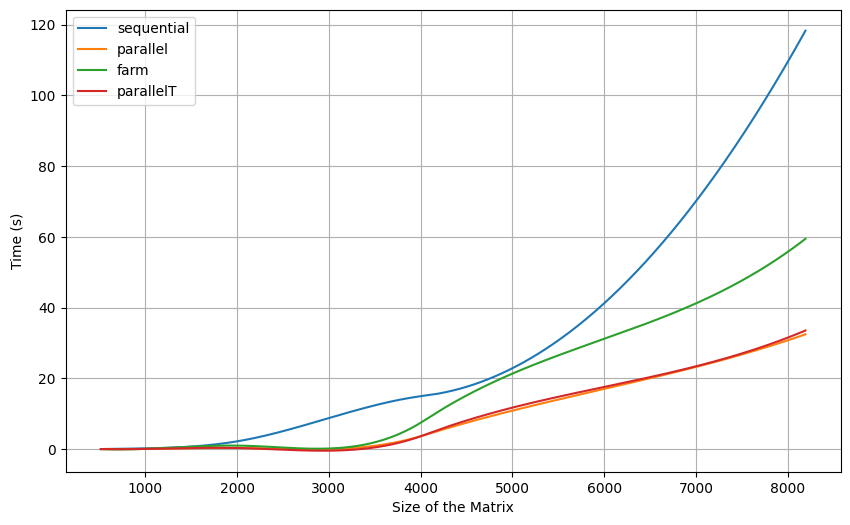

In [439]:
plot_time_vs_size(numa, 8, "numa")

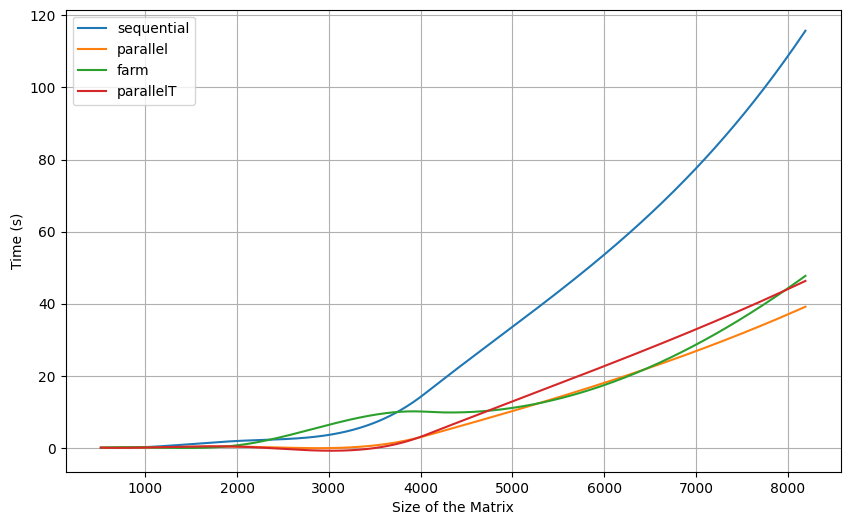

In [435]:
data = numa2

seq = data[data['method'] == 'seq']
frm = data[data['method'] == 'frm']
par = data[data['method'] == 'par']
prT = data[data['method'] == 'prT']

workers = data['#w'].unique()
nw = workers[5]

plt.figure(figsize=(10, 6))

# Interpolate and smooth for 'seq'
seq_x = seq['size']
seq_y = seq['time']
seq_interp = interp1d(seq_x, seq_y, kind='cubic')  # Cubic interpolation
seq_x_smooth = np.linspace(seq_x.min(), seq_x.max(), 500)  # Dense x values
seq_y_smooth = seq_interp(seq_x_smooth)
plt.plot(seq_x_smooth, seq_y_smooth)

# Interpolate and smooth for 'par'
par_x = par[par['#w'] == nw]['size']
par_y = par[par['#w'] == nw]['time']
par_interp = interp1d(par_x, par_y, kind='cubic')
par_x_smooth = np.linspace(par_x.min(), par_x.max(), 500)
par_y_smooth = par_interp(par_x_smooth)
plt.plot(par_x_smooth, par_y_smooth)

# Interpolate and smooth for 'frm'
frm_x = frm[frm['#w'] == nw]['size']
frm_y = frm[frm['#w'] == nw]['time']
frm_interp = interp1d(frm_x, frm_y, kind='cubic')
frm_x_smooth = np.linspace(frm_x.min(), frm_x.max(), 500)
frm_y_smooth = frm_interp(frm_x_smooth)
plt.plot(frm_x_smooth, frm_y_smooth)

# Interpolate and smooth for 'prT'
prT_x = prT[prT['#w'] == nw]['size']
prT_y = prT[prT['#w'] == nw]['time']
prT_interp = interp1d(prT_x, prT_y, kind='cubic')
prT_x_smooth = np.linspace(prT_x.min(), prT_x.max(), 500)
prT_y_smooth = prT_interp(prT_x_smooth)
plt.plot(prT_x_smooth, prT_y_smooth)

# Add labels, legend, and grid
plt.legend(['sequential', 'parallel', 'farm', 'parallelT'])
plt.xlabel('Size of the Matrix')
plt.ylabel('Time (s)')
plt.grid()
#plt.title(f'Time vs Size of the Matrix for {nw} Workers')

plt.savefig(f'./results/plots/time_{nw}_interpol_numa.png')

In [ ]:
# data = numa_final

# seq = data[data['method'] == 'seq']
# frm = data[data['method'] == 'frm']
# par = data[data['method'] == 'par']
# prT = data[data['method'] == 'prT']

# nw = workers[4]

# plt.figure(figsize=(10, 6))
# plt.plot(seq['size'], seq['time'])
# # use interpolation to smooth the curve


# plt.plot(par[par['#w'] == nw]['size'], par[par['#w'] == nw]['time'])
# plt.plot(frm[frm['#w'] == nw]['size'], frm[frm['#w'] == nw]['time'])
# plt.plot(prT[prT['#w'] == nw]['size'], prT[prT['#w'] == nw]['time'])
# plt.legend(['seq', 'par', 'frm', 'prT'])
# plt.xlabel('Size of the Matrix')
# plt.ylabel('Time (s)')
# plt.grid()

# plt.title('Time vs Size of the Matrix')
# plt.savefig(f'./results/plots/time_{nw}.png')

In [443]:
# Plot Functions
def plot_speedup(data, size, name):
    seq = data[data['method'] == 'seq']
    frm = data[data['method'] == 'frm']
    par = data[data['method'] == 'par']
    prT = data[data['method'] == 'prT']

    plt.figure(figsize=(10, 6))
    plt.plot(par[par['size'] == size]['#w'], par[par['size'] == size]['#w'], linestyle='--')
    plt.plot(par[par['size'] == size]['#w'], par[par['size'] == size]['speedup'], marker='o')
    plt.plot(frm[frm['size'] == size]['#w'], frm[frm['size'] == size]['speedup'], marker='o')
    plt.plot(prT[prT['size'] == size]['#w'], prT[prT['size'] == size]['speedup'], marker='o')
    plt.legend(['ideal', 'parallel', 'farm', 'parallelT'])
    plt.xlabel('Number of Workers')
    plt.ylabel('Speedup')
    plt.xticks(par[par['size'] == size]['#w'] )
    plt.yticks(par[par['size'] == size]['#w'] )
    plt.grid()

    # plt.title('Speedup vs Number of Workers')
    plt.savefig(f'./results/plots/speedup_{size}_{name}.png',  bbox_inches='tight')

def plot_efficiency(data, size, name):
    seq = data[data['method'] == 'seq']
    frm = data[data['method'] == 'frm']
    par = data[data['method'] == 'par']
    prT = data[data['method'] == 'prT']

    plt.figure(figsize=(10, 6))
    plt.plot(par[par['size'] == size]['#w'], np.ones(len(par[par['size'] == size]['#w'])), linestyle='--')

    plt.plot(par[par['size'] == size]['#w'], par[par['size'] == size]['efficiency'], marker='o')
    plt.plot(frm[frm['size'] == size]['#w'], frm[frm['size'] == size]['efficiency'], marker='o')
    plt.plot(prT[prT['size'] == size]['#w'], prT[prT['size'] == size]['efficiency'], marker='o')
    plt.xlabel('Number of Workers')
    plt.ylabel('Efficiency')
    plt.xticks(par[par['size'] == size]['#w'])
    plt.legend(['ideal', 'parallel', 'farm', 'parallelT'])
    plt.grid(True)

    # plt.title('Efficiency vs Number of Workers')
    plt.savefig(f'./results/plots/efficiency_{size}_{name}.png', bbox_inches='tight')

# plot scalability
def plot_scalability(data, size, name):
    seq = data[data['method'] == 'seq']
    frm = data[data['method'] == 'frm']
    par = data[data['method'] == 'par']
    prT = data[data['method'] == 'prT']

    plt.figure(figsize=(10, 6))
    plt.plot(par[par['size'] == size]['#w'], par[par['size'] == size]['#w'], linestyle='--')
    plt.plot(par[par['size'] == size]['#w'], par[par['size'] == size]['scalability'], marker='o')
    plt.plot(frm[frm['size'] == size]['#w'], frm[frm['size'] == size]['scalability'], marker='o')
    plt.plot(prT[prT['size'] == size]['#w'], prT[prT['size'] == size]['scalability'], marker='o')
    plt.xlabel('Number of Workers')
    plt.ylabel('Scalability')
    plt.xticks(par[par['size'] == size]['#w'])
    plt.legend(['ideal', 'parallel', 'farm', 'parallelT'])
    plt.grid(True)

    # plt.title('Scalability vs Number of Workers')
    plt.savefig(f'./results/plots/scalability_{size}_{name}.png',  bbox_inches='tight')


In [444]:
sizes = node['size'].unique()
sizes

array([ 516, 1024, 2048, 4000, 4096, 8001, 8192])

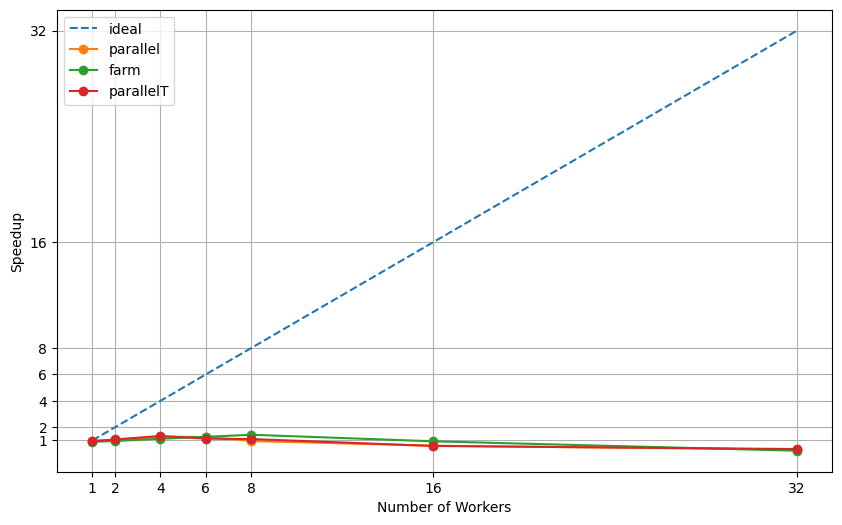

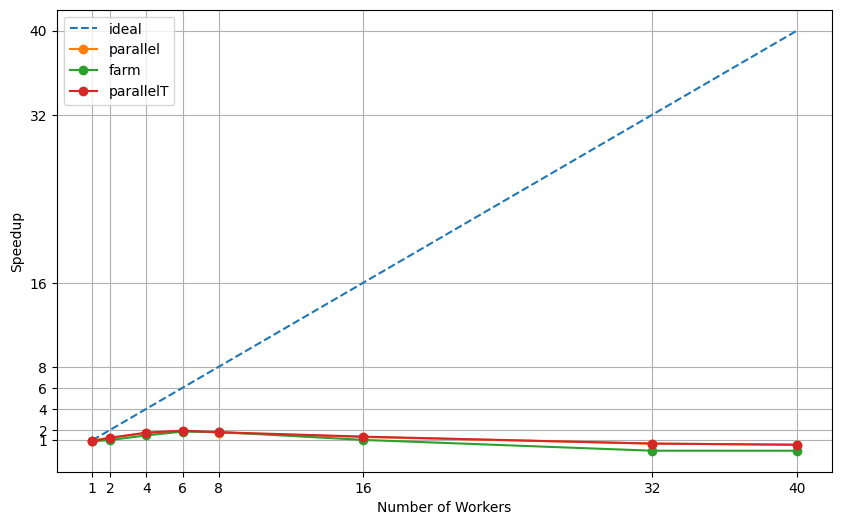

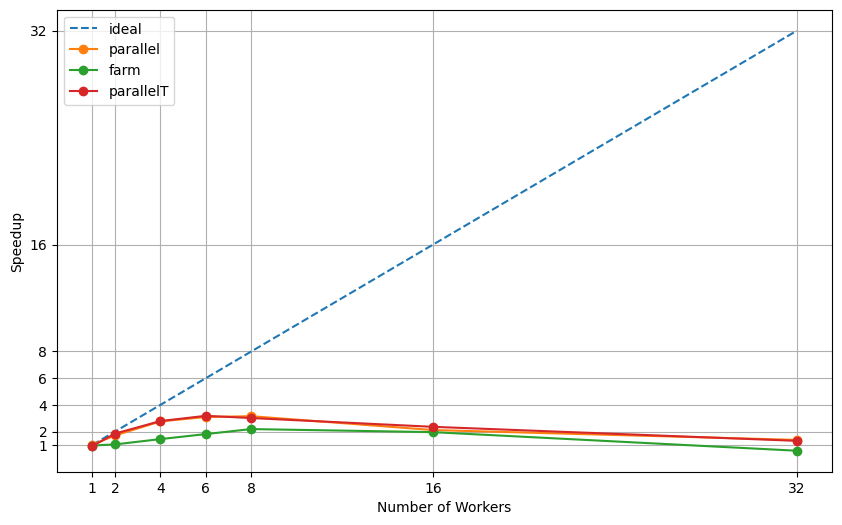

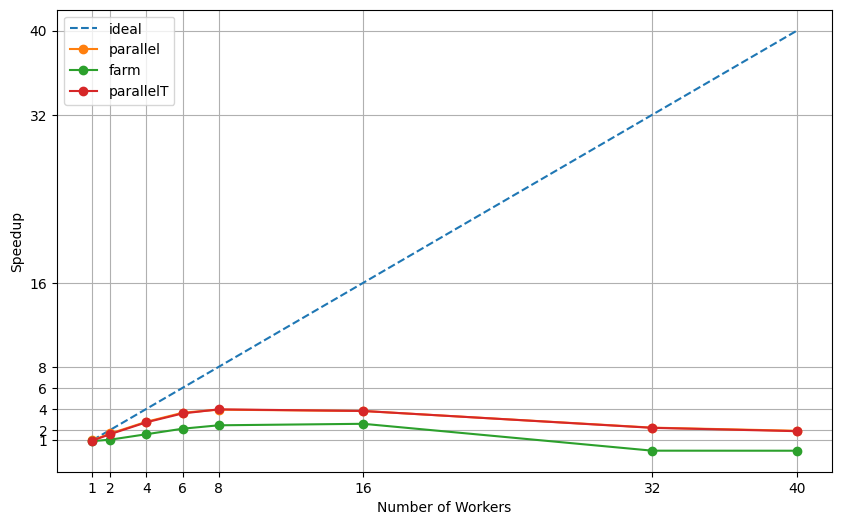

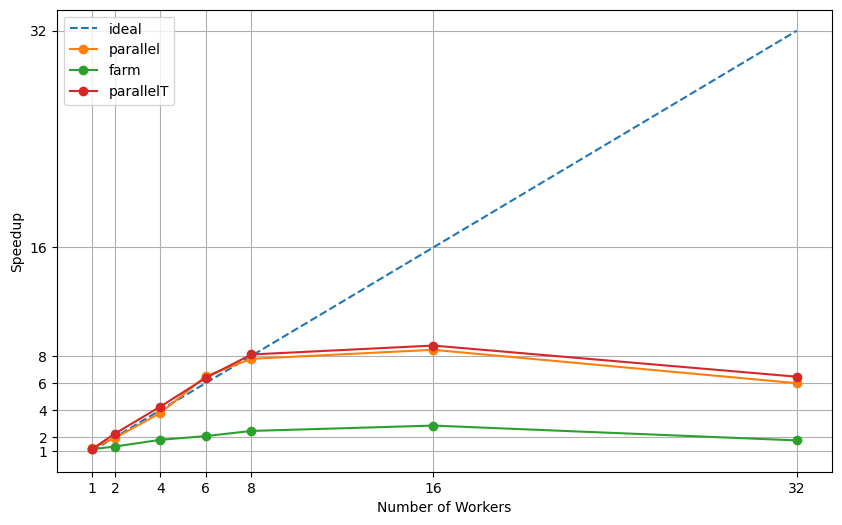

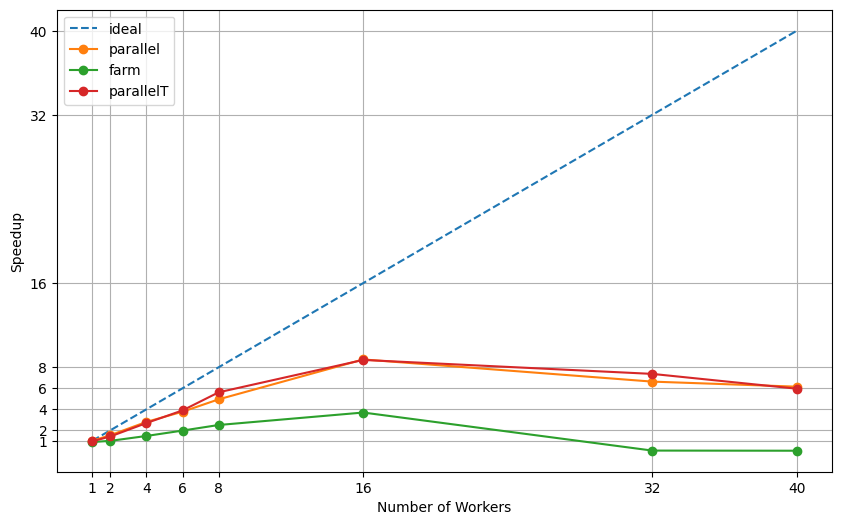

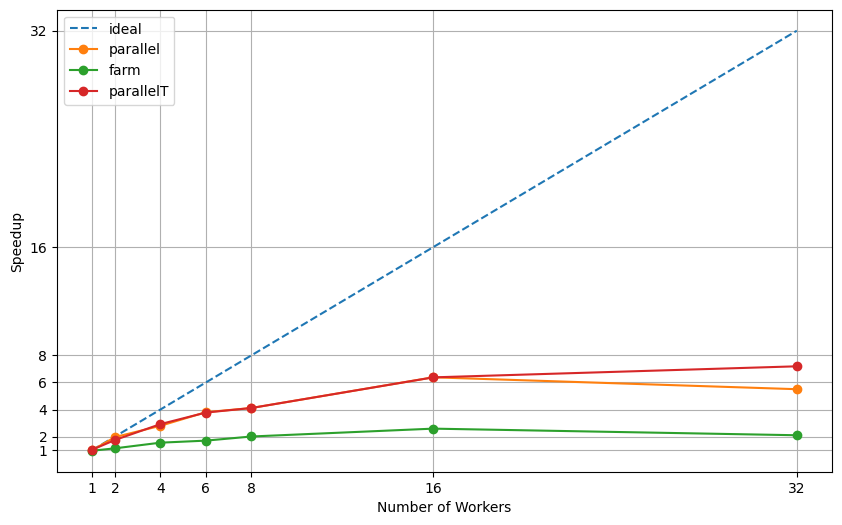

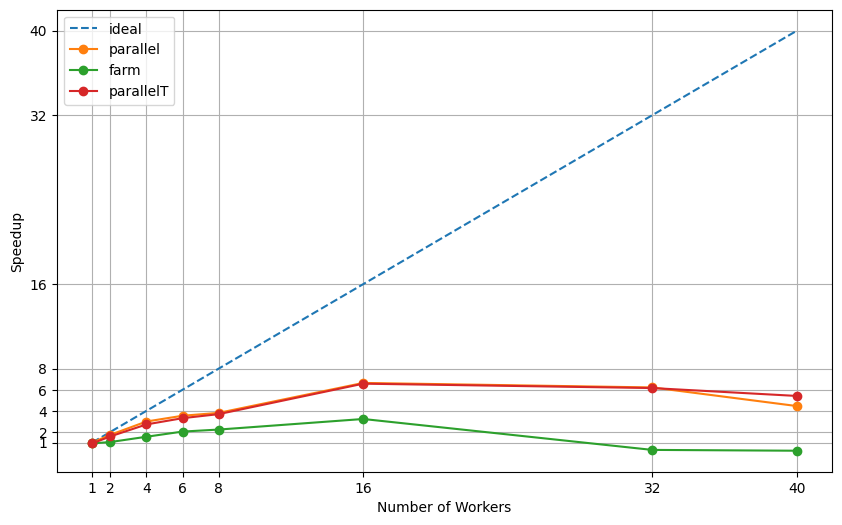

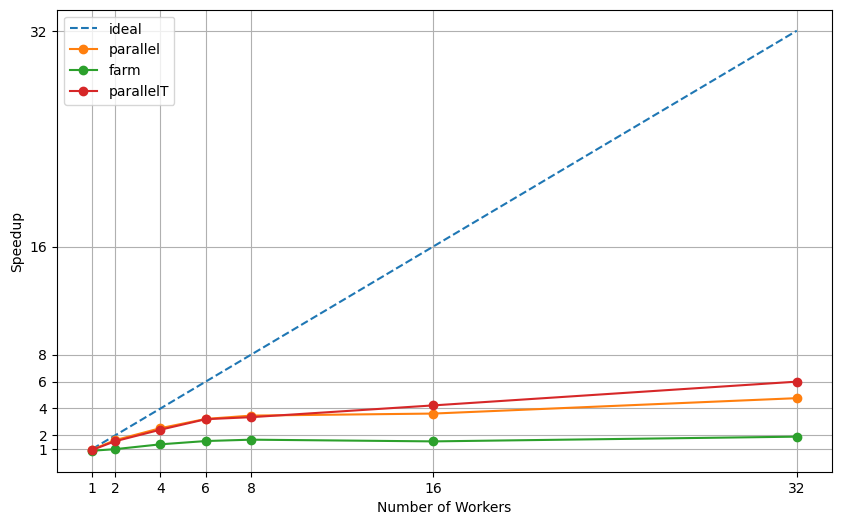

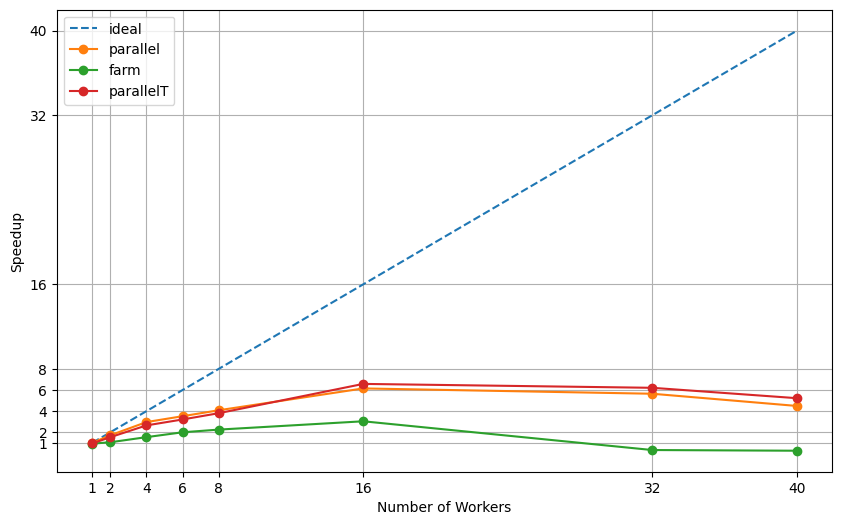

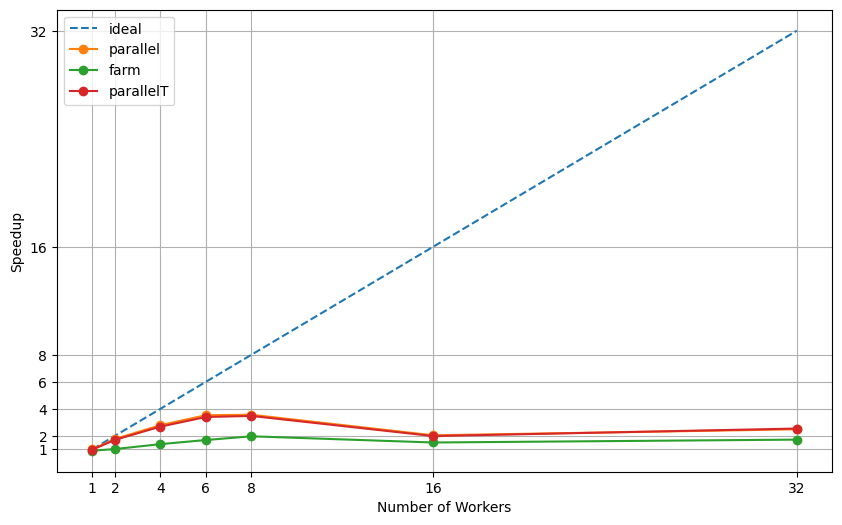

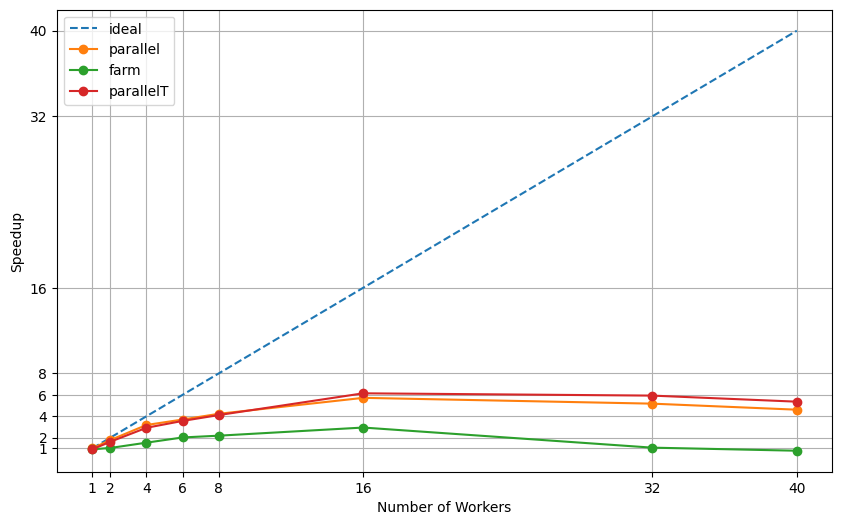

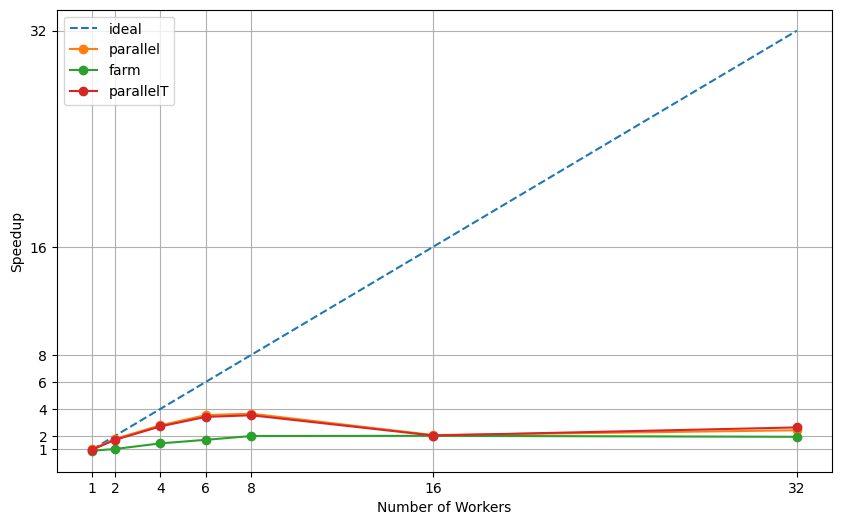

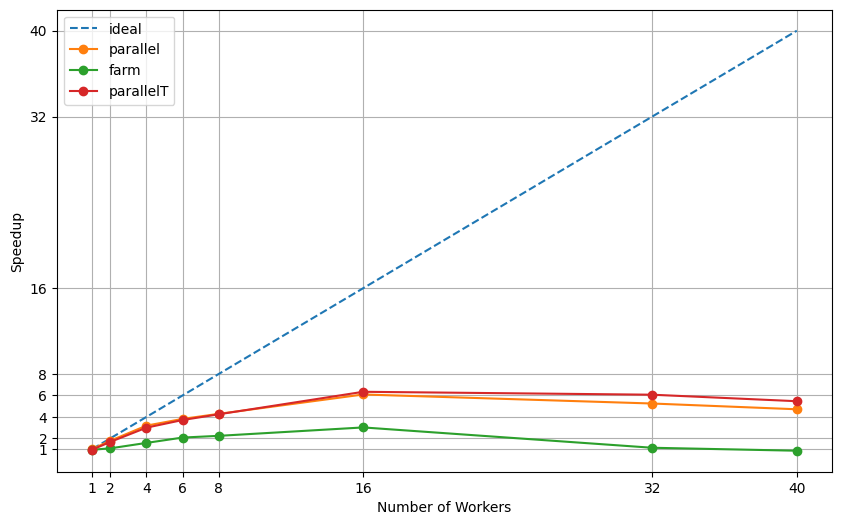

In [445]:
for i in range(7):
    plot_speedup(numa, sizes[i], "numa")
    plot_speedup(node, sizes[i], "node")

/tmp/ipykernel_3882/1416130816.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


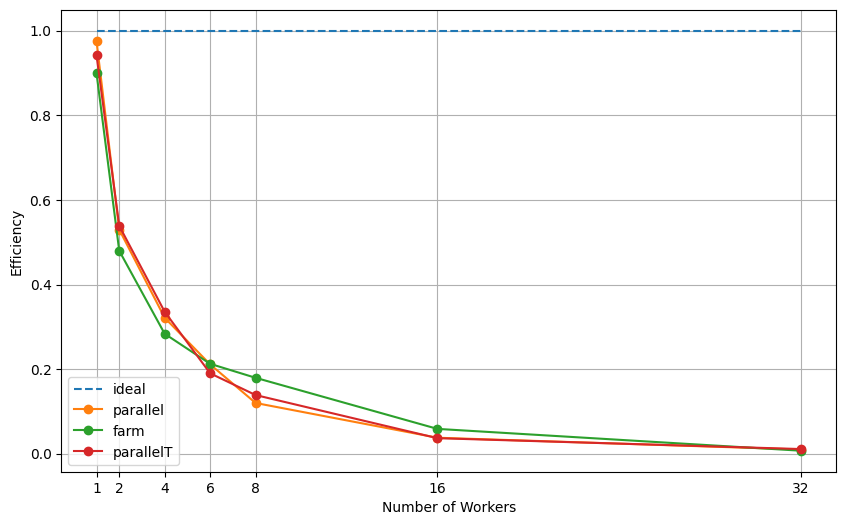

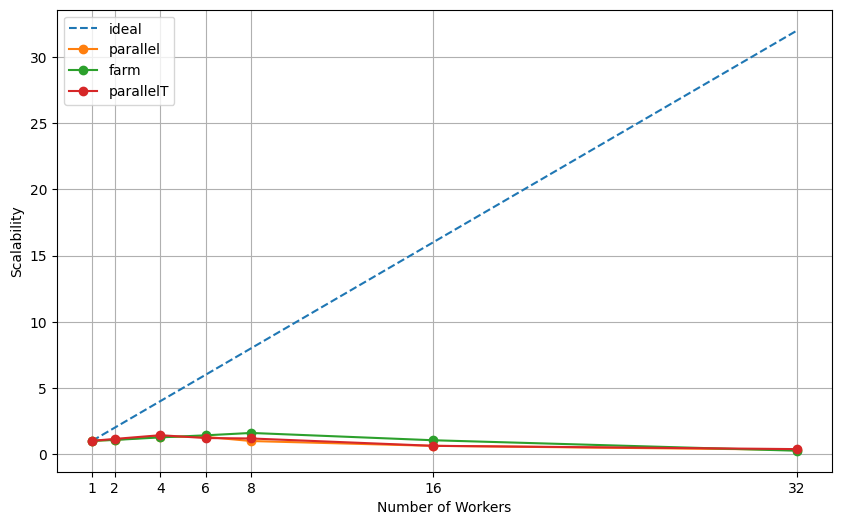

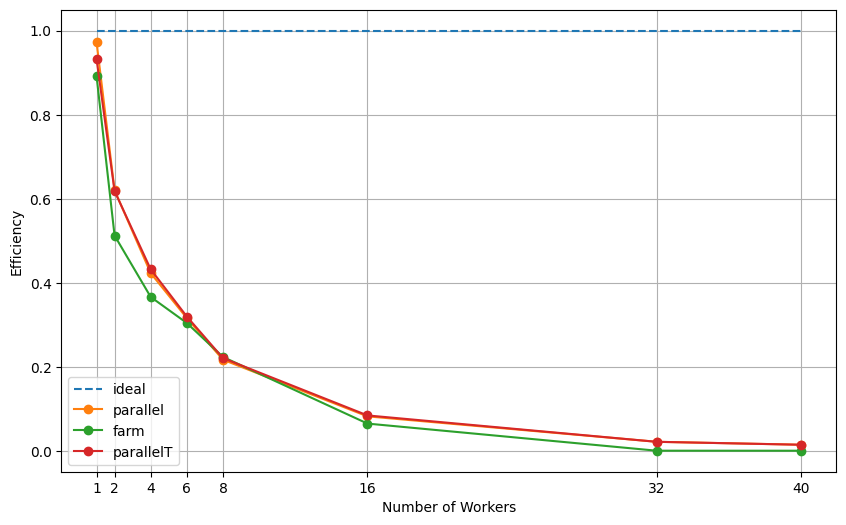

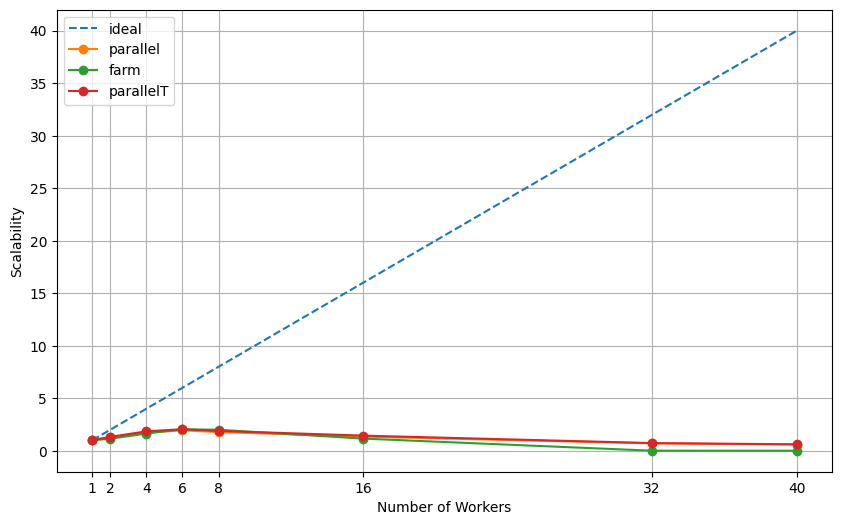

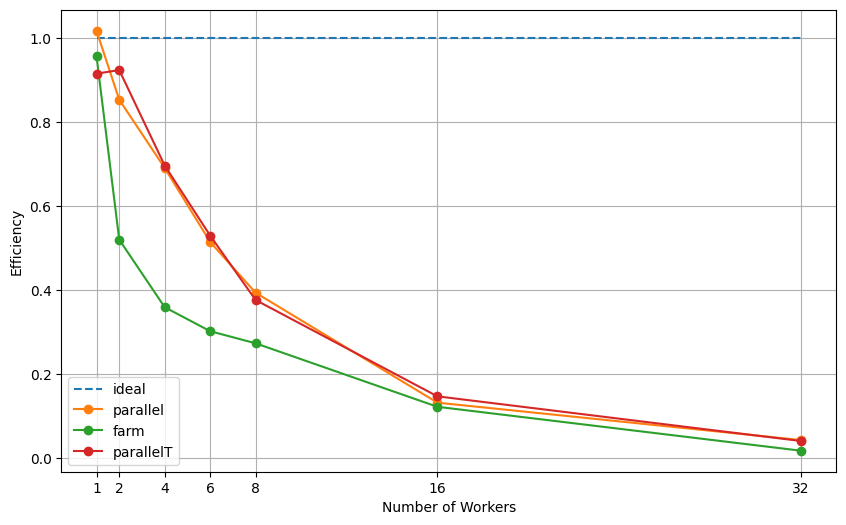

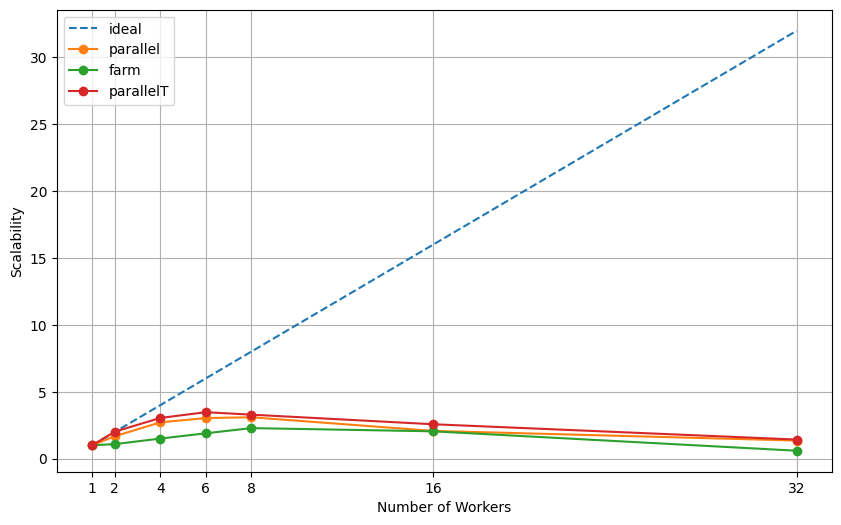

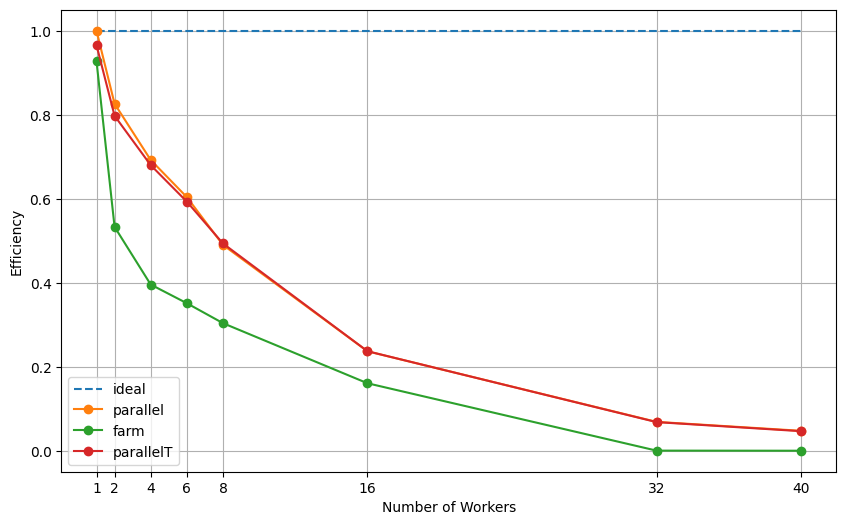

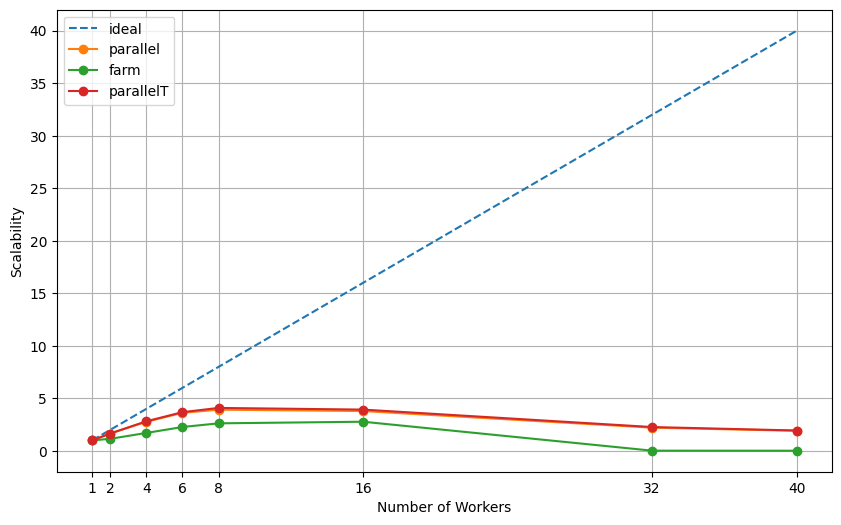

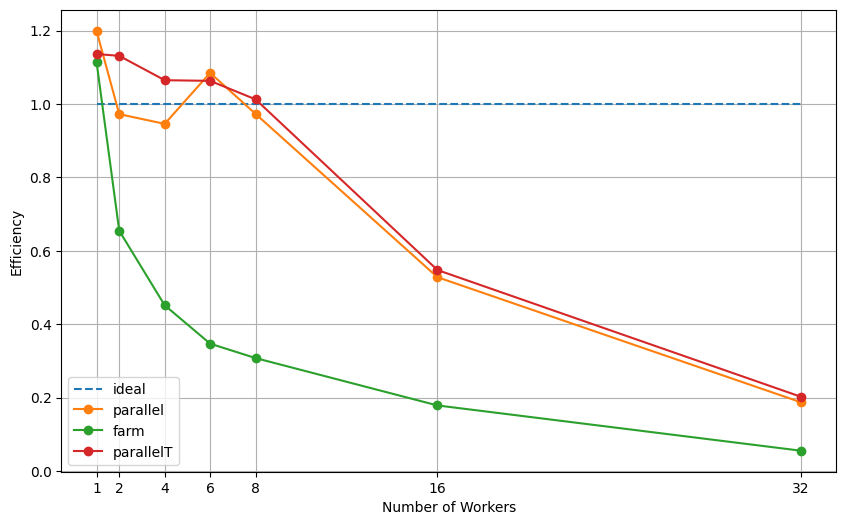

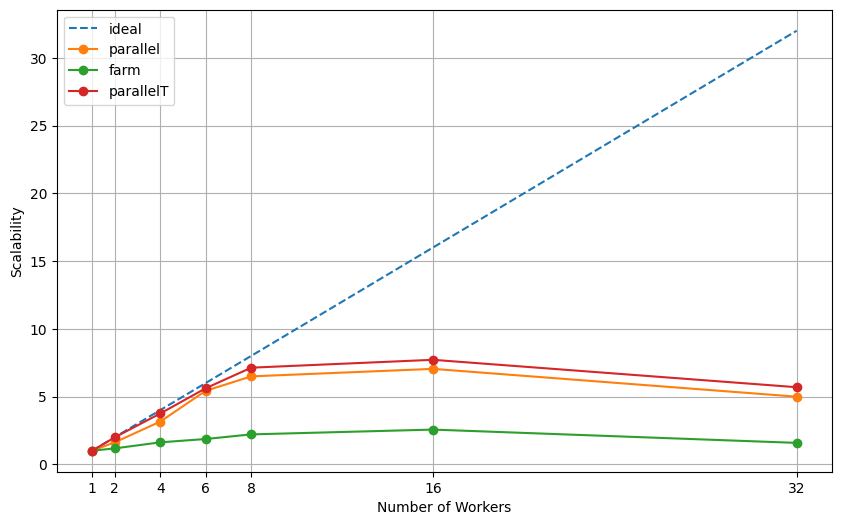

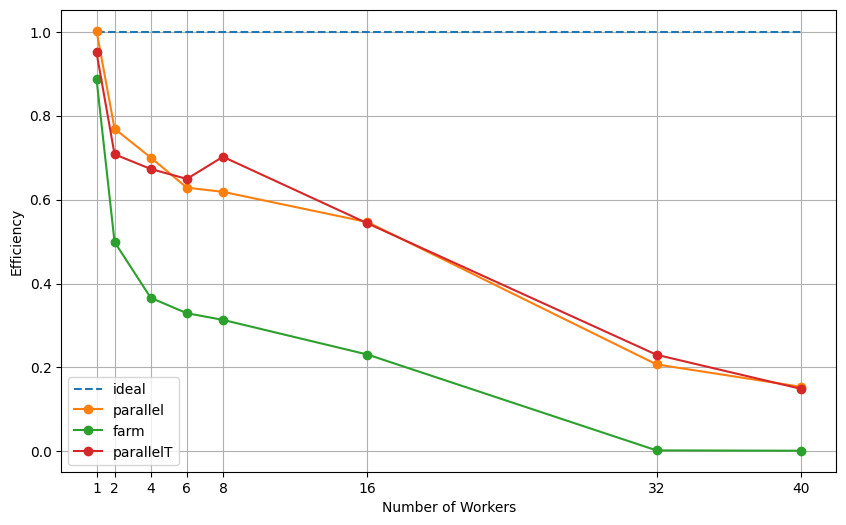

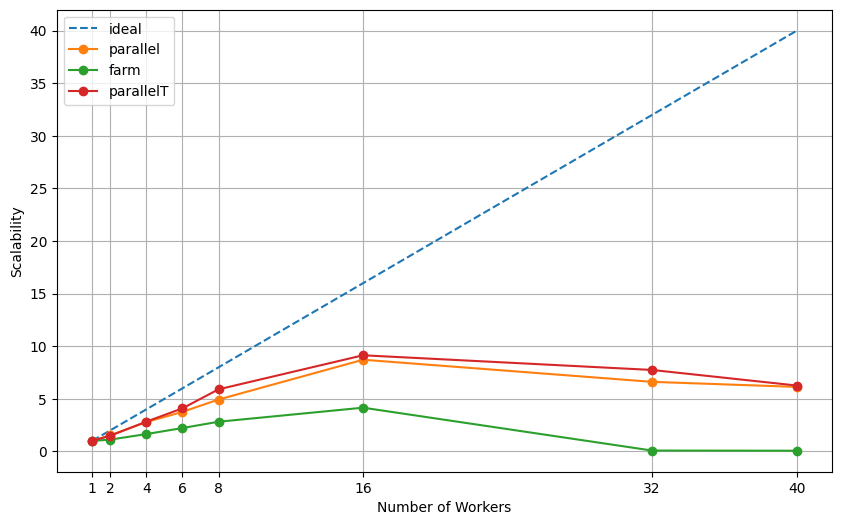

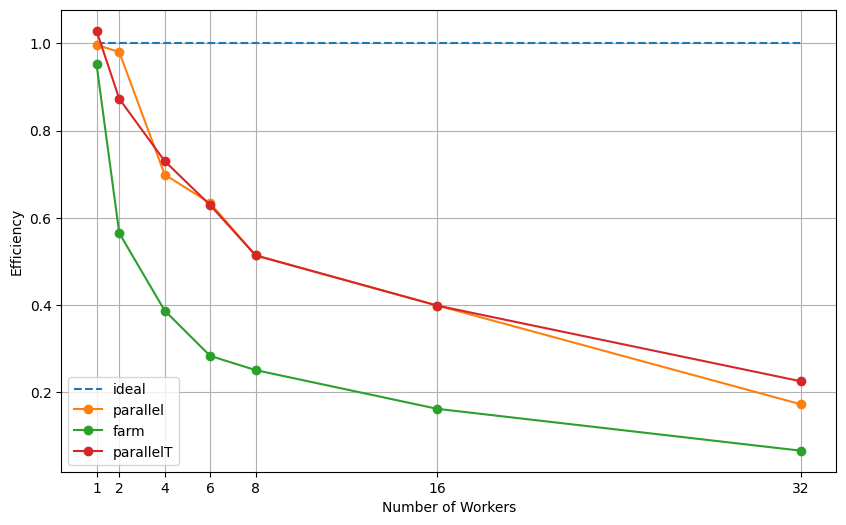

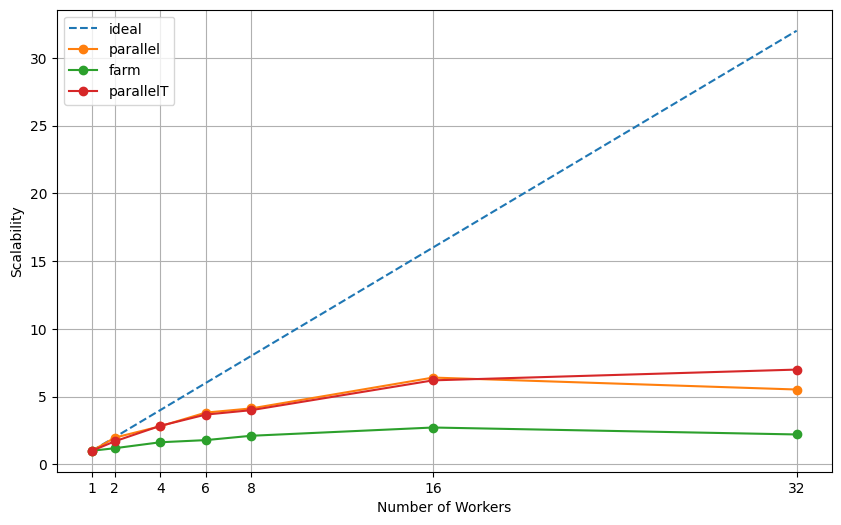

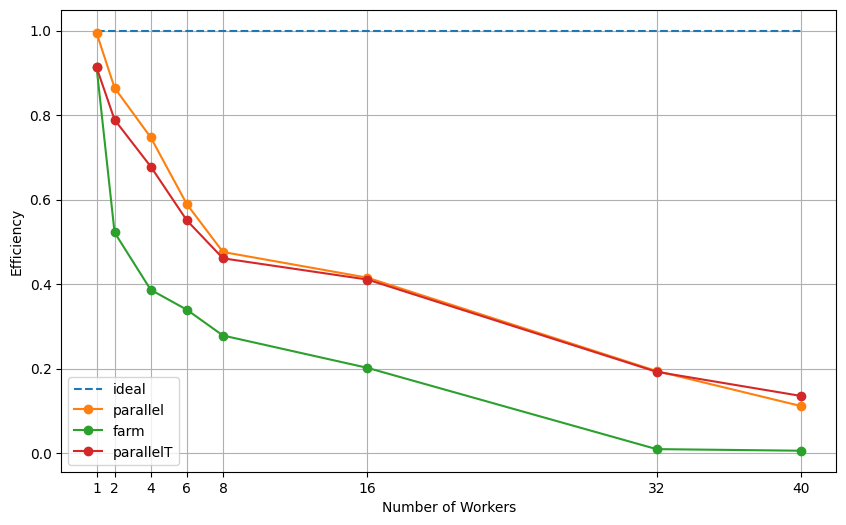

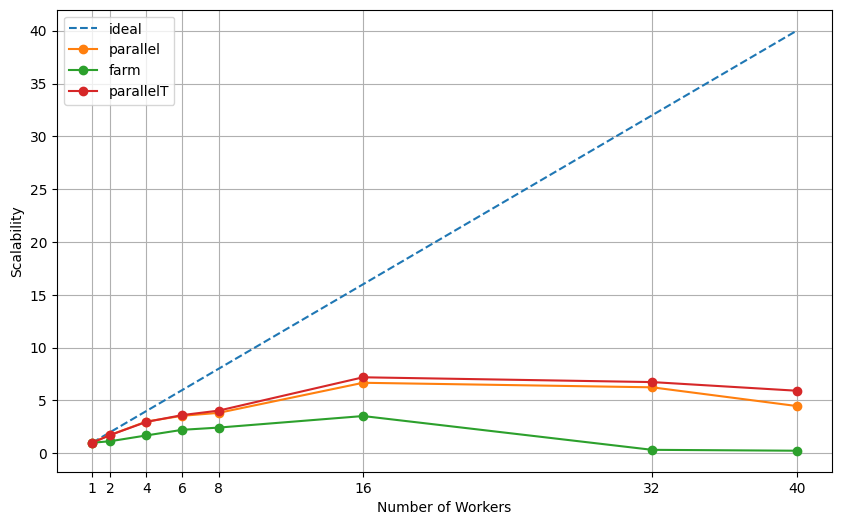

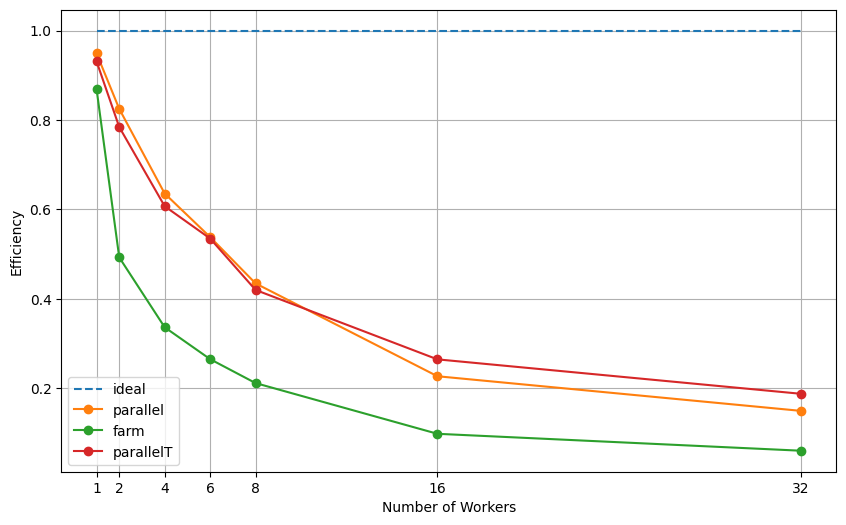

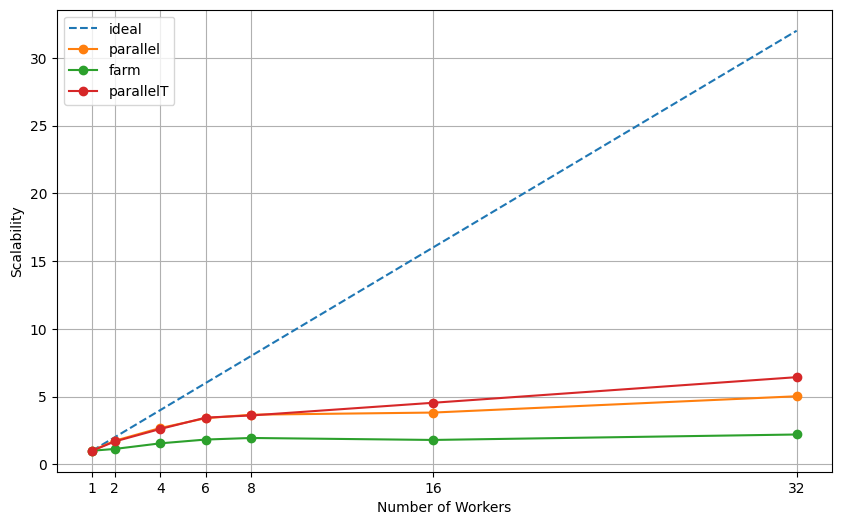

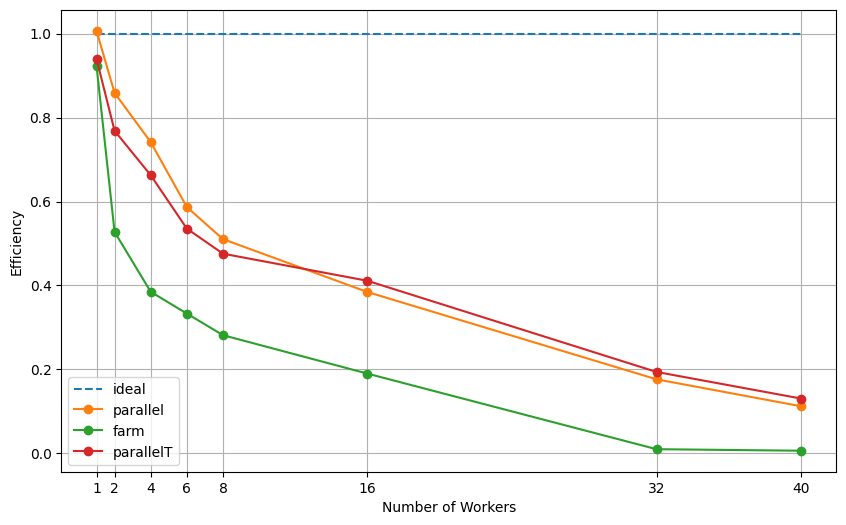

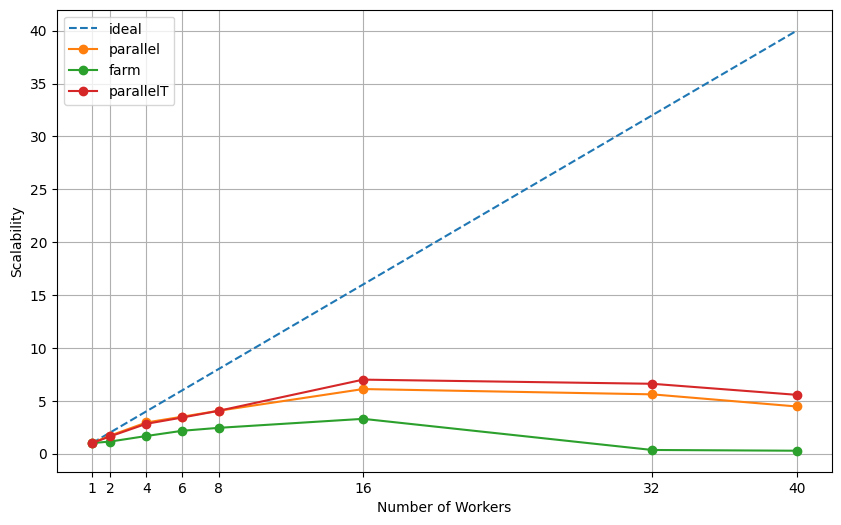

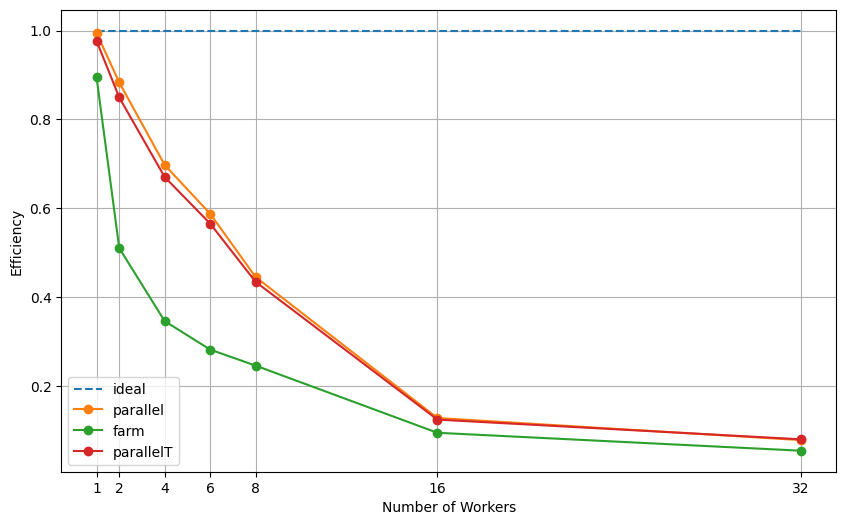

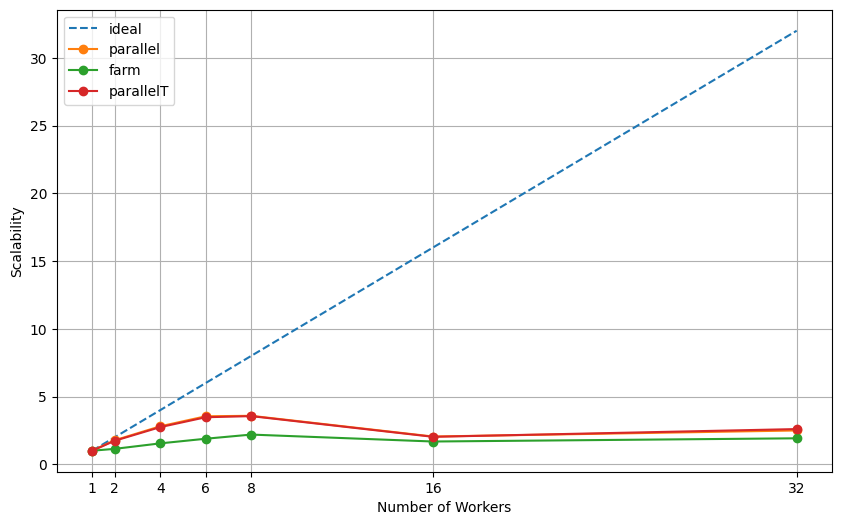

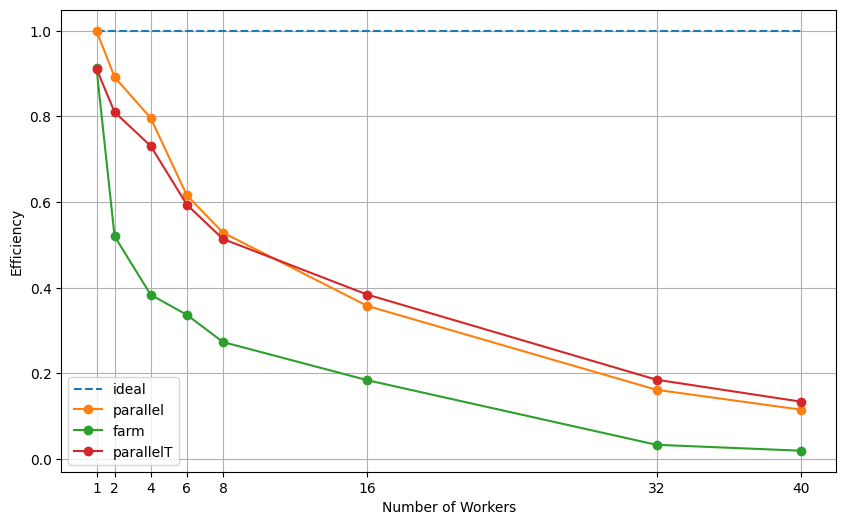

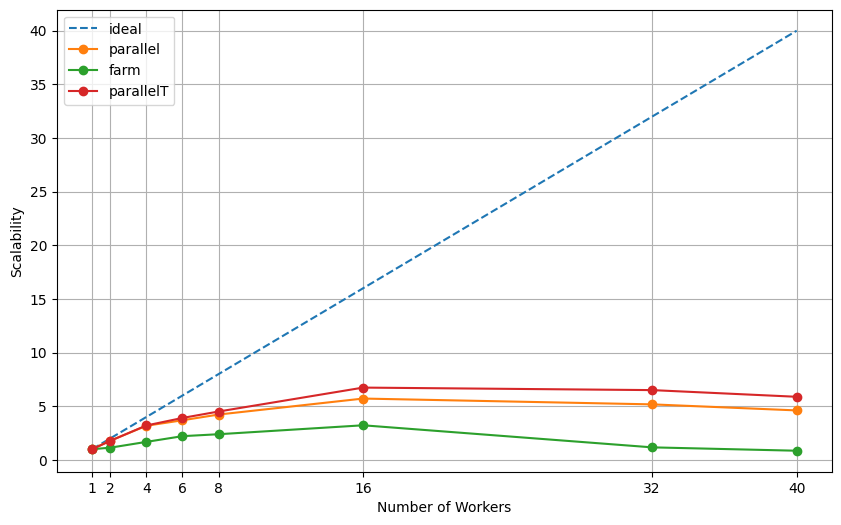

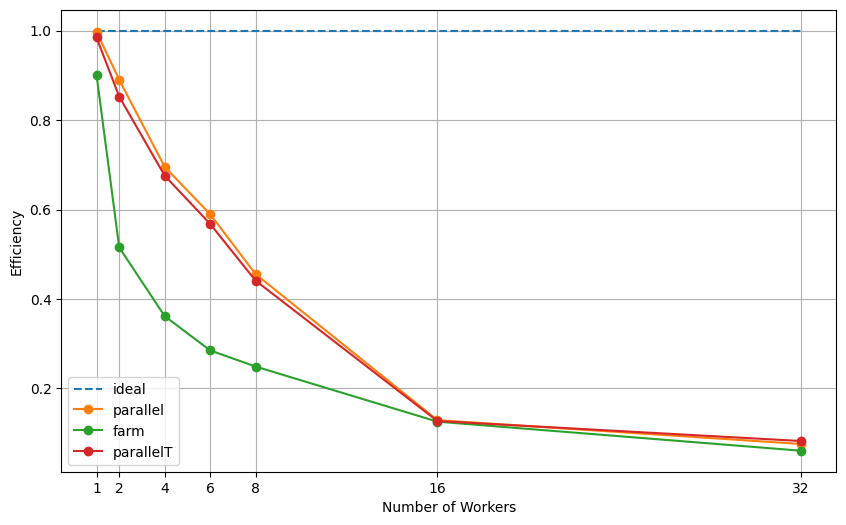

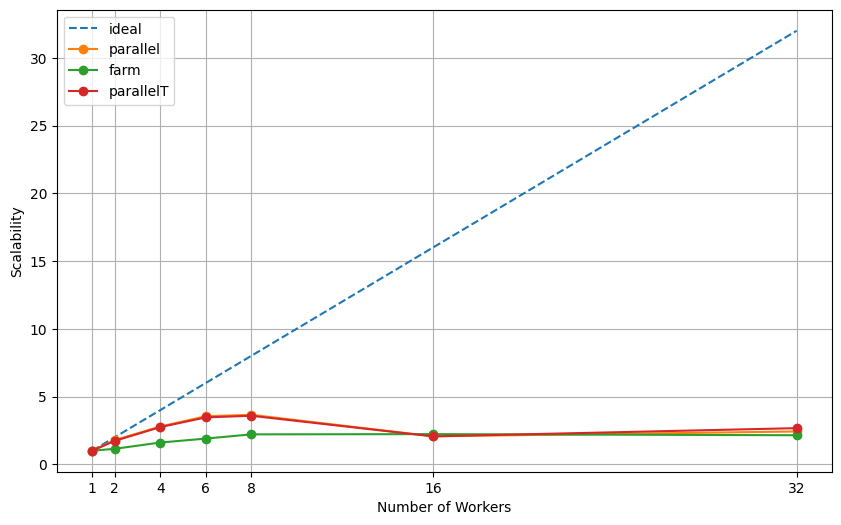

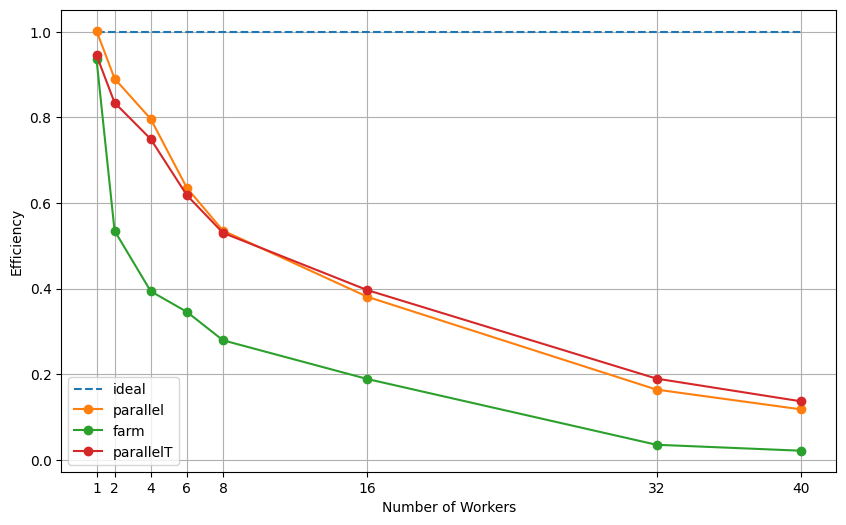

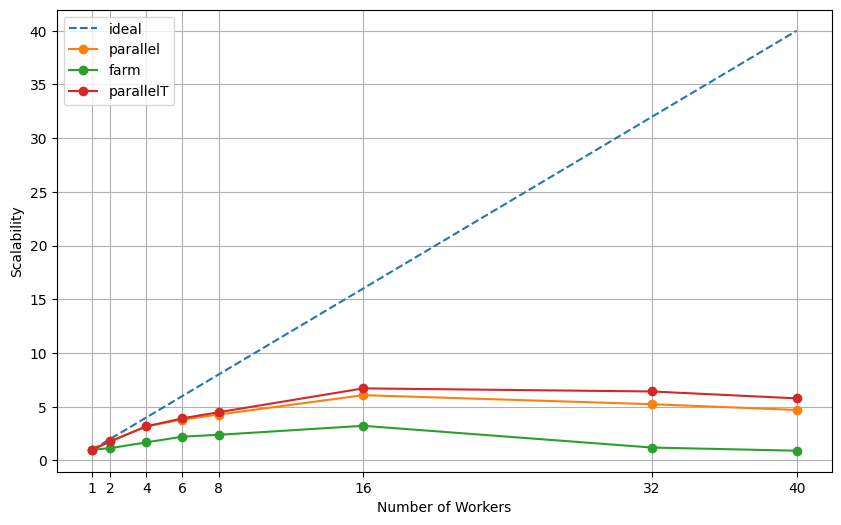

In [448]:
for i in range(7):
    plot_efficiency(numa, sizes[i], "numa")
    plot_scalability(numa, sizes[i], "numa")
    plot_efficiency(node, sizes[i], "node")
    plot_scalability(node, sizes[i], "node")

In [447]:
df = numa
# Filter for rows where method is 'par', #w is 8, and size is 2048
par_filtered = df[(df['size'] == 2048) & (df['method'] == 'par')]

# Get the seq time for the same size
seq_filtered = df[(df['method'] == 'seq') & (df['size'] == 2048)]

# Combine the filtered results for LaTeX output
result_df = pd.concat([seq_filtered[['method', '#w','size', 'time']], par_filtered[['method', 'size', '#w', 'time']]])

print(result_df)

   method  #w  size      time
44    seq   1  2048  2.422729
46    par   1  2048  2.019102
49    par   2  2048  1.245575
52    par   4  2048  0.640275
55    par   6  2048  0.372168
58    par   8  2048  0.311229
61    par  16  2048  0.286742
64    par  32  2048  0.404762


In [39]:
# Load the CSV file
mpi_path = './results/mpi/mpi_final.csv' 
mpi2_path = './results/mpi/mpi_final1.csv'
mpi3_path = './results/mpi/mpi_final_with16384.csv'

mpi = pd.read_csv(mpi_path)
mpi2 = pd.read_csv(mpi2_path)
mpi3 = pd.read_csv(mpi3_path)

In [40]:
mpi3

,size,task_per_node,nodes,time
0,1024,1,1,0.255062
1,1024,2,1,0.138209
2,1024,4,1,0.095357
3,1024,1,2,0.233004
4,1024,2,2,0.095630
...,...,...,...,...
139,16384,2,7,112.501314
140,16384,4,7,99.356979
141,16384,1,8,157.925452
142,16384,2,8,96.010064


In [7]:
data = node
seq = data[data['method'] == 'seq']

In [41]:
mpi.sort_values(by=['nodes', 'size', 'task_per_node'], ascending=True, inplace=True)
mpi = mpi3

In [42]:
# Merge the original DataFrame with seq_df on the 'size' column
merged_df = pd.merge(mpi, seq[['size', 'time']], on='size', how='inner', suffixes=('', '_seq'))

# Rename the time column from the seq DataFrame
merged_df.rename(columns={'time_seq': 'seq_time'}, inplace=True)
merged_df.sort_values(by=['nodes', 'size', 'task_per_node'], ascending=True, inplace=True)
# add the speedup column
merged_df['speedup'] = merged_df['seq_time'] / merged_df['time']

# add the efficiency column
merged_df['efficiency'] = merged_df['speedup'] / merged_df['nodes']

# Display the merged DataFrame with the new seq_time column
print(merged_df)

    size  task_per_node  nodes       time    seq_time   speedup  efficiency
0   1024              1      1   0.255062    0.258003  1.011531    1.011531
1   1024              2      1   0.138209    0.258003  1.866760    1.866760
2   1024              4      1   0.095357    0.258003  2.705653    2.705653
24  2048              1      1   1.979870    2.004673  1.012528    1.012528
25  2048              2      1   1.079803    2.004673  1.856517    1.856517
..   ...            ...    ...        ...         ...       ...         ...
70  4096              2      8   2.084771   17.825665  8.550419    1.068802
71  4096              4      8   2.108665   17.825665  8.453531    1.056691
93  8192              1      8  21.912352  139.644797  6.372880    0.796610
94  8192              2      8  14.713023  139.644797  9.491238    1.186405
95  8192              4      8  19.526976  139.644797  7.151379    0.893922

[96 rows x 7 columns]


In [43]:
#orderby nodes value
merged_df = merged_df.sort_values(by=['nodes'])
merged_df

,size,task_per_node,nodes,time,seq_time,speedup,efficiency
0,1024,1,1,0.255062,0.258003,1.011531,1.011531
1,1024,2,1,0.138209,0.258003,1.866760,1.866760
2,1024,4,1,0.095357,0.258003,2.705653,2.705653
24,2048,1,1,1.979870,2.004673,1.012528,1.012528
25,2048,2,1,1.079803,2.004673,1.856517,1.856517
...,...,...,...,...,...,...,...
70,4096,2,8,2.084771,17.825665,8.550419,1.068802
71,4096,4,8,2.108665,17.825665,8.453531,1.056691
93,8192,1,8,21.912352,139.644797,6.372880,0.796610
94,8192,2,8,14.713023,139.644797,9.491238,1.186405


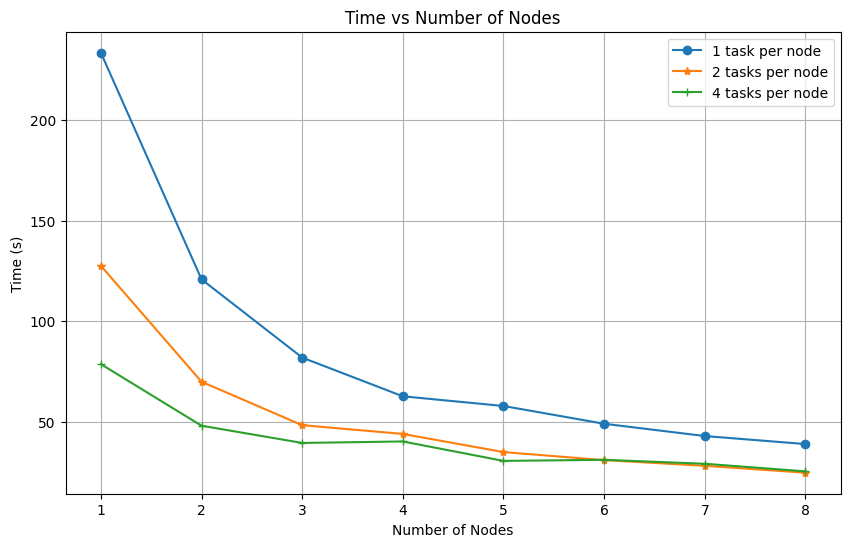

In [44]:
# fixed the size of the matrix to 10000, plot how the times changes with the number of nodes

data = mpi
size = 10000
data_time = data[(data['size'] == size) & (data['task_per_node'] == 1)]
data_time2 = data[(data['size'] == size) & (data['task_per_node'] == 2)]
data_time4 = data[(data['size'] == size) & (data['task_per_node'] == 4)]

plt.figure(figsize=(10, 6))
plt.plot(data_time['nodes'], data_time['time'], marker='o')
plt.plot(data_time2['nodes'], data_time2['time'], marker='*')
plt.plot(data_time4['nodes'], data_time4['time'], marker='+')

# add more line per task per node
plt.xlabel('Number of Nodes')
plt.ylabel('Time (s)')
plt.legend(['1 task per node', '2 tasks per node', '4 tasks per node'])
plt.title('Time vs Number of Nodes')
plt.grid()

plt.savefig(f'./results/plots/mpi_time_vs_nodes_{size}.png')

In [529]:
merged_df

,size,task_per_node,nodes,time,seq_time,speedup,efficiency
0,1024,1,2,0.233004,0.253731,1.088956,0.544478
1,1024,2,2,0.095630,0.253731,2.653257,1.326629
2,1024,4,2,0.059364,0.253731,4.274156,2.137078
3,1024,1,3,0.236875,0.253731,1.071160,0.357053
4,1024,2,3,0.173886,0.253731,1.459180,0.486393
...,...,...,...,...,...,...,...
91,4096,2,1,9.328890,17.555038,1.881793,1.881793
92,4096,4,1,5.691801,17.555038,3.084268,3.084268
93,8192,1,1,132.809220,137.245044,1.033400,1.033400
94,8192,2,1,76.401425,137.245044,1.796368,1.796368


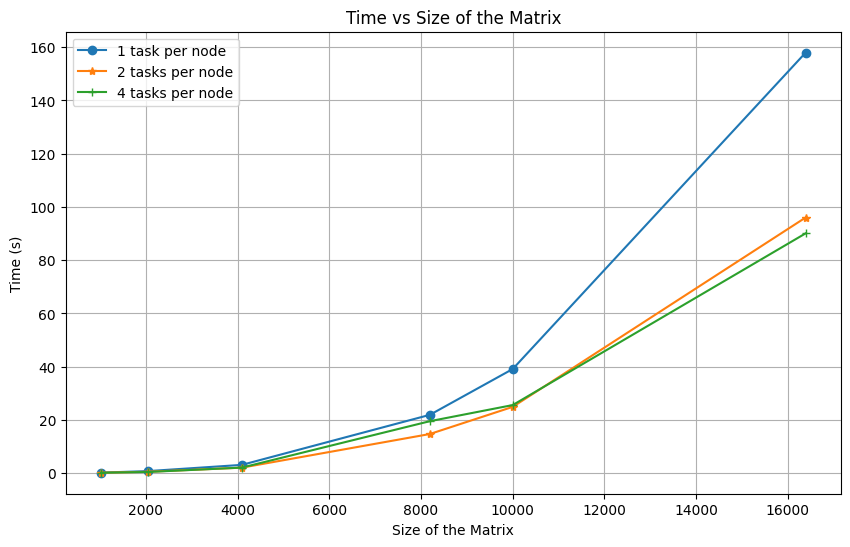

In [47]:
# fix the number of nodes to 8, plot how the times changes with the size of the matrix

data = mpi3
nodes = 8
data_time = data[(data['nodes'] == nodes) & (data['task_per_node'] == 1)]
data_time2 = data[(data['nodes'] == nodes) & (data['task_per_node'] == 2)]
data_time4 = data[(data['nodes'] == nodes) & (data['task_per_node'] == 4)]

plt.figure(figsize=(10, 6))
plt.plot(data_time['size'], data_time['time'], marker='o')
plt.plot(data_time2['size'], data_time2['time'], marker='*')
plt.plot(data_time4['size'], data_time4['time'], marker='+')

# add more line per task per node
plt.xlabel('Size of the Matrix')
plt.ylabel('Time (s)')
plt.legend(['1 task per node', '2 tasks per node', '4 tasks per node'])
plt.title('Time vs Size of the Matrix')
plt.grid()

plt.savefig(f'./results/plots/mpi_time_vs_task_{nodes}.png',  bbox_inches='tight')



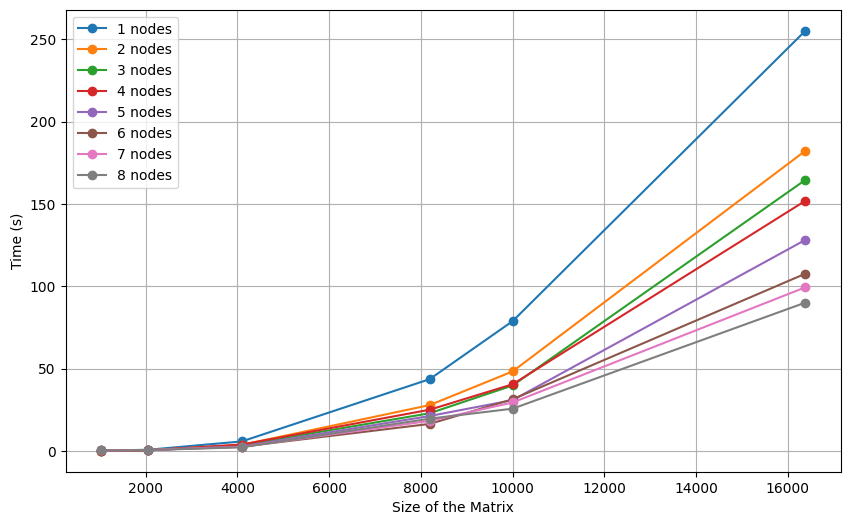

In [51]:
# fix the number of tasks per node to 1, plot how the times changes with the size of the matrix and plot also the sequential time

data = mpi3
tasks = 4
data_time = data[(data['task_per_node'] == tasks)]


plt.figure(figsize=(10, 6))
#print one line for each note from 1 to 8
#plt.plot(data_time['size'], data_time['seq_time'], marker='o', label='sequential')
for i in range(1, 9):
    data_time2 = data_time[data_time['nodes'] == i]
    plt.plot(data_time2['size'], data_time2['time'], marker='o', label=f'{i} nodes')

plt.xlabel('Size of the Matrix')
plt.ylabel('Time (s)')
# plt.legend([ 'sequential','1 node', '2 nodes', '3 nodes', '4 nodes', '5 nodes', '6 nodes', '7 nodes', '8 nodes'])
plt.legend()
plt.grid()
plt.savefig(f'./results/plots/mpi_time_vs_size_{tasks}.png', bbox_inches='tight')

In [20]:
# Plot Functions
def plot_efficiency_mpi(data, size, name):
    size1 = 2048
    size2 = 8192
    plt.figure(figsize=(10, 6))
    plt.plot(data[data['size'] == size]['nodes'], np.ones(len(data[data['size'] == size]['nodes'])), linestyle='--')
    plt.plot(data[data['size'] == size1]['nodes'], data[data['size'] == size1]['efficiency'], marker='o')
    plt.plot(data[data['size'] == size2]['nodes'], data[data['size'] == size2]['efficiency'], marker='o')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Efficiency')
    plt.xticks(data[data['size'] == size]['nodes'])
    plt.legend(['ideal', 'mpi 2048', 'mpi 8192'])
    plt.grid(True)

    # plt.title('Efficiency vs Number of Workers')
    plt.savefig(f'./results/plots/mpi_efficiency_{size}_{name}.png', bbox_inches='tight')

def plot_speedup_mpi(data, size, name):
    size1 = 2048
    size2 = 8192

    plt.figure(figsize=(10, 6))
    plt.plot(data[data['size'] == size]['nodes'], data[data['size'] == size]['nodes'], linestyle='--')
    plt.plot(data[data['size'] == size1]['nodes'], data[data['size'] == size1]['speedup'], marker='o')
    plt.plot(data[data['size'] == size2]['nodes'], data[data['size'] == size2]['speedup'], marker='o')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Speedup')
    plt.xticks(data[data['size'] == size]['nodes'])
    plt.legend(['ideal', 'mpi 2048', 'mpi 8192'])
    plt.grid(True)

    # plt.title('Speedup vs Number of Workers')
    plt.savefig(f'./results/plots/mpi_speedup_{size}_{name}.png',  bbox_inches='tight')

def plot_scalability_mpi(data, size, name):
    size1 = 2048
    size2 = 8192

    plt.figure(figsize=(10, 6))
    plt.plot(data[data['size'] == size]['nodes'], data[data['size'] == size]['nodes'], linestyle='--')
    plt.plot(data[data['size'] == size1]['nodes'], data[data['size'] == size1]['scalability'], marker='o')
    plt.plot(data[data['size'] == size2]['nodes'], data[data['size'] == size2]['scalability'], marker='o')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Scalability')
    plt.xticks(data[data['size'] == size]['nodes'])
    plt.legend(['ideal', 'mpi 2048', 'mpi 8192'])
    plt.grid(True)

    # plt.title('Scalability vs Number of Workers')
    plt.savefig(f'./results/plots/mpi_scalability_{size}_{name}.png',  bbox_inches='tight')


In [14]:
data = merged_df
tasks = 1
data_speedup = data[(data['task_per_node'] == tasks)]
sizes = data_speedup['size'].unique()
sizes

array([1024, 2048, 4096, 8192])

In [556]:
merged_df

,size,task_per_node,nodes,time,seq_time,speedup,efficiency
84,1024,1,1,0.255062,0.253731,0.994782,0.994782
85,1024,2,1,0.138209,0.253731,1.835850,1.835850
86,1024,4,1,0.095357,0.253731,2.660853,2.660853
87,2048,1,1,1.979870,1.999077,1.009701,1.009701
88,2048,2,1,1.079803,1.999077,1.851335,1.851335
...,...,...,...,...,...,...,...
61,4096,2,8,2.084771,17.555038,8.420607,1.052576
62,4096,4,8,2.108665,17.555038,8.325191,1.040649
81,8192,1,8,21.912352,137.245044,6.263364,0.782921
82,8192,2,8,14.713023,137.245044,9.328134,1.166017


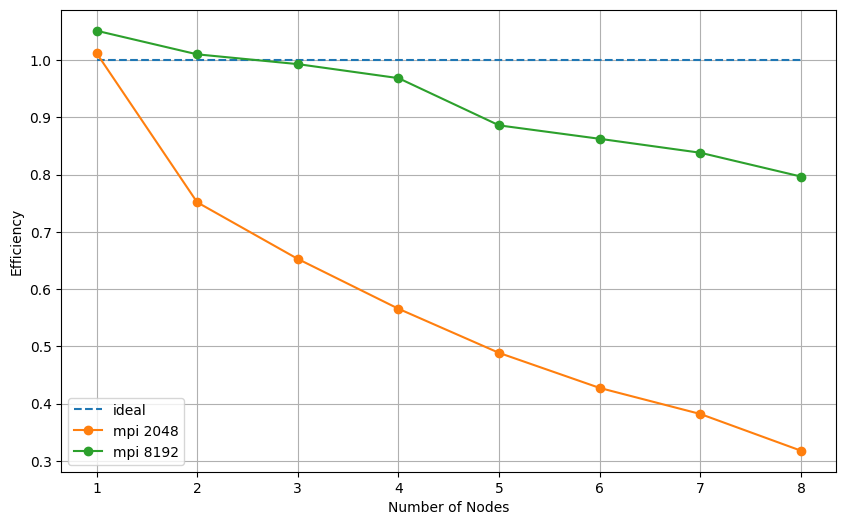

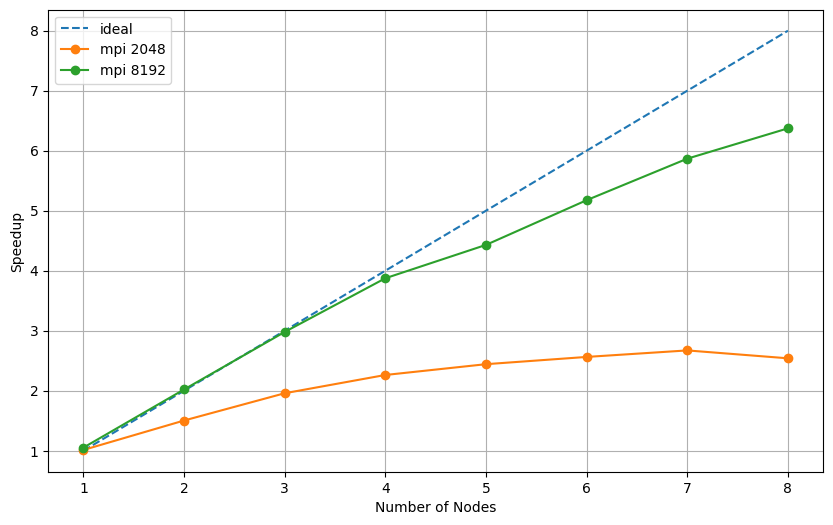

In [23]:
data = merged_df
tasks = 1
data_speedup = data[(data['task_per_node'] == tasks)]


plot_efficiency_mpi(data_speedup, 2048, "mpi2")
plot_speedup_mpi(data_speedup, 2048, "mpi2")

In [16]:
#compute scalability comparing the time with node != 1 divided by time of node = 1

merged_df['scalability'] = merged_df.groupby('size')['time'].transform(lambda x: x.iloc[0] / x)

merged_df


,size,task_per_node,nodes,time,seq_time,speedup,efficiency,scalability
0,1024,1,1,0.255062,0.258003,1.011531,1.011531,1.000000
1,1024,2,1,0.138209,0.258003,1.866760,1.866760,1.845480
2,1024,4,1,0.095357,0.258003,2.705653,2.705653,2.674811
3,2048,1,1,1.979870,2.004673,1.012528,1.012528,1.000000
4,2048,2,1,1.079803,2.004673,1.856517,1.856517,1.833547
...,...,...,...,...,...,...,...,...
91,4096,2,8,2.084771,17.825665,8.550419,1.068802,8.168742
92,4096,4,8,2.108665,17.825665,8.453531,1.056691,8.076179
93,8192,1,8,21.912352,139.644797,6.372880,0.796610,6.060929
94,8192,2,8,14.713023,139.644797,9.491238,1.186405,9.026644


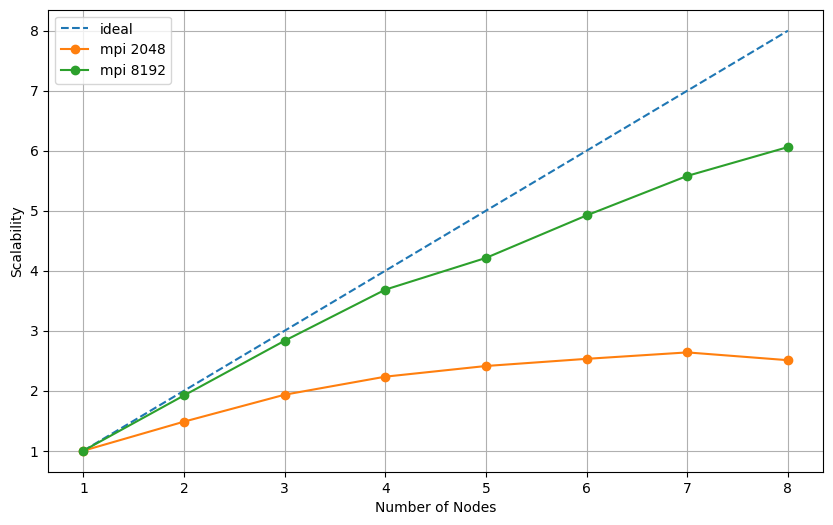

In [21]:

plot_scalability_mpi(data_speedup, 2048, "mpi")

In [24]:
sizes = merged_df['size'].unique()
size = sizes[3]
# calculate number of processes, number of processes are task per node * nodes

merged_df_time = merged_df[(merged_df['size'] == size) & (merged_df['task_per_node'] == 1)]
merged_df_time2 = merged_df[(merged_df['size'] == size) & (merged_df['task_per_node'] == 2)]
merged_df_time2['speedup'] = merged_df_time2['speedup'] / 2
merged_df_time4 = merged_df[(merged_df['size'] == size) & (merged_df['task_per_node'] == 4)]
merged_df_time4['speedup'] = merged_df_time4['speedup'] / 4

# # calculate number of processes, number of processes are task per node * nodes
# merged_df_time['processes'] = merged_df_time['task_per_node'] * merged_df_time['nodes']
# merged_df_time2['processes'] = merged_df_time2['task_per_node'] * merged_df_time2['nodes']
# merged_df_time4['processes'] = merged_df_time4['task_per_node'] * merged_df_time4['nodes']

/tmp/ipykernel_175960/735936346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_time2['speedup'] = merged_df_time2['speedup'] / 2
/tmp/ipykernel_175960/735936346.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_time4['speedup'] = merged_df_time4['speedup'] / 4


In [26]:
sizes[3]

np.int64(8192)

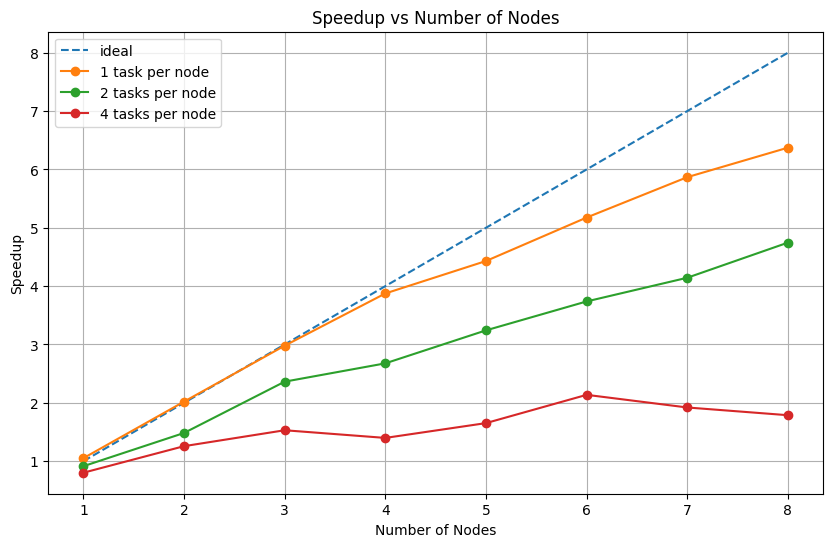

In [28]:
# plot the speedup vs number of processes, number of processes are task per node * nodes

plt.figure(figsize=(10, 6))
#ideal speedup
plt.plot(merged_df_time['nodes'], merged_df_time['nodes'], linestyle='--')
plt.plot(merged_df_time['nodes'], merged_df_time['speedup'], marker='o')
plt.plot(merged_df_time2['nodes'], merged_df_time2['speedup'], marker='o')
plt.plot(merged_df_time4['nodes'], merged_df_time4['speedup'], marker='o')

plt.xlabel('Number of Nodes')
plt.ylabel('Speedup')

plt.title('Speedup vs Number of Nodes')
plt.grid()

plt.legend(['ideal', '1 task per node', '2 tasks per node', '4 tasks per node'])
plt.savefig(f'./results/plots/mpi_speedup_vs_nodes_{size}.png')